# Introduction

Clustering algorithms are useful tools in data mining and analysis. They are used to partition data into clusters of similar points, which can provide useful insights about the dataset. In the following, using the R programming language, we implement the Spectral Clustering algorithm which is based on the more widely used Kmeans clustering algorithm. Both algorithms will be visualized for comparison on two basic datasets (a simulated point cloud in in $\mathbb{R}^3$ and the Iris Flower dataset).

# Kmeans++

As stated above, Kmeans is a popular clustering algorithm, favored for its simplicity and efficiency. In the following we implement an enhanced version called Kmeans++ which uses the $D^2$ seeding method to improve the initialization phase. Once initialized, the algorithm simply optimizes the clusters by iteratively updating their centers, until convergence.

## Auxiliary functions :

### $D^2$ random distribution :

The following algorithm returns a random index using a discrete (non negative) weight distribution w.

In [1]:
random = function(w){
    n = length(w)
    # discrete cumulative distribution 
    p = cumsum(w)
    # simulate probability using Inverse Transform Sampling
    u = runif(1,0,p[n])
    # find the index of the inverse using dichotomic search
    a = 0
    b = n
    # loop invariant : a<b and p[a]<=u<p[b]
    while(b-a>1){
        c = a + (b-a)%/%2
        if (p[c]>u){
            b = c
        } else {
            a = c
        }
    }
    return(b)
}

### Euclidien distance

The following function computes the square of the euclidien distance between two vectors x and y.

In [2]:
dist2 = function(x, y){
    return (t(x-y)%*%(x-y))
}

###  Cluster partitioning

* The following algorithm returns the indexing vector for the clusters obtained by partitioning the dataset *X* using a set of cluster centers *C*.

In [3]:
iclusters = function(X, C){
    # sample size
    n = ncol(X)
    # cluster count
    k = ncol(C)
    # Cindex will contain the index of the nearest center
    Cindex = vector("double", n)
    # partitioning sample over cluster centers
    for (x in 1:n){
        d = dist2(X[,x],C[,1])
        Cindex[x] = 1
        for (c in 2:k){
            if (dist2(X[,x],C[,c]) < d){
                d = dist2(X[,x],C[,c])
                Cindex[x] = c
            }
        }
    }
    return(Cindex)
}

* The following algorithm returns the list of clusters obtained by partitioning the dataset *X* using the indexing vector *index*.

In [4]:
clusters = function(X, index){
    # cluster count
    k = ncol(C)
    # constructing the list of clusters
    clist = vector("list", k)
    for (c in 1:k){
        cindex = Cindex==c
        clist[[c]] = X[,cindex]
    }
    return(clist)
}

## $D^2$ seeding method

The following algorithm returns a matrix of k randomly chosen initial centers from a dataset X, using the D² seeding method which works recursively as follows :

* Choose the first center $C_1$ uniformely at random from X

* Given the first $C = \{C_1,...C_{i-1}\}$ centers chosen, choose the next center $C_i$ at random from X using the probability distribution :
$\bigg(\dfrac{D(x)^2}{\sum_{x\in X} D(x)^2}\bigg)_{x\in X}$ where $D(x) = \min\big\{||x-c||:c\in C\big\}$ 

In [5]:
d2seed = function(X, k){
    # sample dimensions
    d = nrow(X)
    n = ncol(X)
    # allocate a dxk matrix for the centers
    C = matrix(NA_real_, d, k)
    # choose first center uniformely from the sample
    i = floor(runif(1,0,n))
    C[,1] = X[,i+1]
    # calculate initial weight distribution
    d2 = vector("double", n)
    for (i in 1:n){
        d2[i] = dist2(X[,i],C[,1])
    }
    # choose the next (k-1) remaining centers using the D² method
    for (c in 2:k){
        # select the next center using auxiliary function
        r = random(d2)
        C[,c] = X[,r]
        # update weight distribution
        for (i in 1:n){
            d2[i] = min(d2[i], dist2(X[,i],C[,c]))
        }
    }
    return(C)
}

## Kmeans++ algorithm

The following algorithm returns a matrix of k cluster centers for a dataset X, using the Kmeans algorithm initialized with the $D^2$ seeding method. The iter argument specifies the maximum number of iterations of the optimization loop.

In [6]:
kmpp = function(X, k, iter=0){
    # sample size
    n = ncol(X)
    # initialization of cluster centers
    C = d2seed(X,k)
    # optimization loop
    repeat{
        # Cindex will contain the index of the nearest scenter
        Cindex = vector("double",n)
        # partitioning sample over cluster centers
        for (x in 1:n){
            d = dist2(X[,x],C[,1])
            Cindex[x] = 1
            for (c in 2:k){
                if (dist2(X[,x],C[,c]) < d){
                    d = dist2(X[,x],C[,c])
                    Cindex[x] = c
                }
            }
        }
        # updating cluster centers
        convergence = TRUE
        for (c in 1:k){
            index = Cindex==c
            size = sum(index)
            cluster = X[,index]
            if (size>1){
                newcenter = rowSums(cluster)/size
            } else {
                newcenter = cluster
            }            
            if (all(newcenter!=C[,c])){
                convergence = FALSE
                C[,c] = newcenter
            }
        }
        iter = iter-1
        if(convergence || iter==0){
            break
        }
    }
    return(C)
}

# Spectral Clustering

## Basic definitions

### Graph notation

Let $G = (V,E)$ be an undirected graph with vertex set $V = \{v_1, . . . ,v_2\}$. In the following we assume
that the graph G is weighted, that is each edge between two vertices $v_i$ and $v_j$ carries a non-negative
weight $w_{ij} ≥ 0$.
The weighted adjacency matrix of the graph $G$ is the matrix $W = (w_{ij})$ $i,j=1,...,n$.

The degree of a vertex $v_i \in V$ is defined as $d_i = \sum\limits_{j=1}^n w_{ij}$.

The degree matrix $D$ is defined as the diagonal matrix with the degrees $d_1, . . . , d_n$
on the diagonal.





### Similarity graphs

There are several constructions to transform a given set $x_1, . . . , x_n$ of data points with pairwise
similarities $s_{ij}$ or pairwise distances $d_{ij}$ into a graph. When constructing similarity graphs the goal is
to model the local neighborhood relationships between the data points.

- The ε-neighborhood graph : We connect all points whose pairwise distances are smaller than ε.

- The k-nearest neighbor graph : Here the goal is to connect vertex $v_i$ with vertex $v_j$ if $v_j$ is among the k-nearest neighbors of $v_i$ but as the neighborhood relationship is not symmetric we consider two different construction.
    - The k-nearest neighbor graph : We ignore the directions of the edges, that is we connect $v_i$ and $v_j$ with an 
undirected edge if $v_i$ is among the k-nearest neighbors of $v_j$ or if $v_j$ is among the k-nearest neighbors of $v_i$.
    - The mutual k-nearest neighbor graph : We connect vertices $v_i$ and $v_j$ if both $v_i$  is among the k-nearest neighbors of $v_j$  and $v_j$  is among the k-nearest neighbors of $v_i$.

- The fully connected graph : Here we simply connect all points with positive similarity with each
other, and we weight all edges by $s_{ij}$ .

### Graph Laplacians and their basic properties

In the following we always assume that G is an undirected, weighted graph with weight matrix $W$,
where $w_ij = w_ji ≥ 0$.

The unnormalized graph Laplacian matrix is defined as $L = D − W$.



## Auxiliary functions

### Similarity graphs

* The following function returns the ε-neighborhood graph, given a distance matrix *d* and a floor *e*.

In [7]:
egraph = function(d,e){
    n=nrow(d)
    for(i in 1:n){
        for(j in i:n){
            if(d[i,j]>e){
                d[i,j]=0
                d[j,i]=0
            } else {
                d[i,j]=1
                d[j,i]=1
            }
        }
    }
    return(d)
}

* The following function returns the k-neighborhood graph, given a distance matrix *d* and a neighborhood size *k*.

In [8]:
knearest = function(k,d,mutual=FALSE){
    n=nrow(d)
    p=ncol(d)
    #Matrix n*p of zero
    M=matrix(data=numeric(n*p),ncol=p,nrow=n)
    for(i in 1:n){
        #Iterate the number of point that we have to connect
        kk=k
        while(kk!=0){
            #Cordinates of the nearest point of i
            #Start at (i,1)
            ii=i
            jj=1
            if(mutual){
                min2=d[1,i] 
                min=d[i,1] 
            }
            else{
                min=min(d[i,1],d[1,i])
            }
            #Found the cordinates of the nearest point of i
            for(j in 1:i){
                if(mutual){
                    if(d[i,j]<min && d[j,i]<min2){
                        min=d[i,j]
                        min2=d[j,i]
                        ii=i
                        jj=j
                    }
                }
                else{
                    if(d[i,j]<min || d[j,i]<min){
                        if(d[i,j]>d[j,i]){ d[i,j]=d[j,i] }
                        min=d[i,j]
                        ii=i
                        jj=j
                    }
                    
                }
            }
            kk=kk-1
            #M take the nearest point which is at (ii,jj)
            #M is symetric
            M[ii,jj]=M[jj,ii]=d[ii,jj]
        }
    }
    return(M)
}

### Degree matrix

The following function computes the degree matrix for a similarity matrix *W*.

In [9]:
degree = function(W){
    n=nrow(W)
    #Allocate a zero matrix length n*n
    D = matrix(data=numeric(n*n), nrow=n, ncol=n)
    for(i in 1:n){
        D[i,i]=sum(W[i,])
    }
    return(D)
}

### Laplacian matrix

The following function computes the Laplacian matrix for a similarity matrix *W*. The *normalized* argument specifies the normalization method to be used for the Laplacian matrix. It is set to 0 (unnormalized) by default.

In [10]:
laplacian = function(W,normalize=0){
    #length of the matrix W
    n=ncol(W)
    #degree matrix
    D=degree(W)
    L=D-W
    #Normalized Laplacian Lsym
    if(normalize==1){
        RD=solve(D^(1/2))
        return(RD*L*RD)
    }
    #Normalized Laplacian Lrw
    if(normalize==2){
        return(solve(D)*L)
    }
    #Unormalized Laplacian of W
    return(L)
}

### k-first eigenvectors

The following functions returns the first *k* eigenvectors (by order of their corresponding eigenvalues) of an input matrix *L*.

In [11]:
eigenvectors = function(L,k){
    #Compute all the eigenvalues and eigenvectors of L
    X=eigen(L)
    #Take the first k eigenvectors
    t=length(X$values)
    return(X$vectors[,(t-k+1):t])
}

## Spectral Clustering algorithms

The idea behind the Spectral Clustering algorithm is to change translate the data into the $\mathbb{R}^k$ vector space, using graph Laplacians. This change of perspective in certain cases, due to the properties of graph Laplacians, improves the clustering results obtained through kmeans clustering.

The following function implements the Spectral Clustering algorithms. It returns a *k*-cluster indexing vector for a similarity matrix *S* using a Spectral Clustering algorithm. The *normalize* argument can be used to specify a Laplacian normalization method (1 for $L_{rw}$ and 2 for $L_{sym}$).

In [12]:
spec = function(S,k,normalize=0){
    # Weighted adjacency matrix of S
    W=S
    # Compute the normalized Laplacian Lrw
    L=laplacian(W,normalize)
    # Compute the first k-eigenvectors of Lrw
    U=eigenvectors(L,k)
    # Normalize the rows
    if(normalize==2){
        n = nrow(U)
        N=(rowSums(U^2)^(1/2))
        for(i in 1:n){
            if (N[i]>0){
                for(j in 1:k){
                    U[i,j]=U[i,j]/N[i]
                }
            }
        }
    }
    # Transpose the matrix U
    Y=t(U)
    # Cluster the points with k-means algorithm
    C=kmpp(Y,k)
    return(iclusters(Y,C))
}

# Numerical application

## Visualisation

The following function performs a multidimentional plot of *k* clusters obtained from a dataset *X* using the indexing vector *index*.
* The *names* vector contains the labels for data coordinates
* The *title* string specifies the title of the image
* The *col* vector specifies cluster colors
* The *shape* value specifies the shape of the dots

In [13]:
pclusters = function(X, k, index, names, title, col = NULL, shape=1){
    # dataset dimension
    d = nrow(X)
    # computing boundaries for the data
    blist = vector("list",d)
    for(i in 1:d){
        blist[[i]] = c(min(X[i,]),max(X[i,]))
    }
    # constructing the list of clusters
    clist = vector("list", k)
    for (c in 1:k){
        bool = index==c
        clist[[c]] = X[,bool]
    }
    # plotting colors
    if (length(col)==0){
        col = c(2:(k+1))
    }
    # adjusting margins
    par(oma=c(2,2,5,2), mar=(c(0,0,0,0)+.5))
    # plotting in R²
    if (d==2){
        plot(clist[[1]][1,],clist[[1]][2,], col = col[1],
             pch=shape, xlab=names[1], ylab=names[2], 
             xlim = blist[[1]], ylim = blist[[2]])
        for (c in 2:k){
            points(clist[[c]][1,],clist[[c]][2,], col = col[c],
                   xlab=names[1], ylab=names[2], pch=shape)
        }
        title(title, outer=TRUE)
    }
    # plotting in higher dimensions
    else {
        par(mfrow=c(d,d))
        for (i in 1:d){
            for (j in 1:d){
                # plotting dimension name
                if (j==i){
                    plot(blist[[i]], blist[[i]], #ann = F,  
                         type = 'n', xaxt = 'n', yaxt = 'n',)
                    text(x = mean(blist[[i]]), y = mean(blist[[i]]),
                         paste(names[i]), cex = 1.25, col = "black")
                } else {
                    # plotting the clusters in [j,i] space
                    if(length(nrow(clist[[1]]))>0){
                        plot(clist[[1]][j,],clist[[1]][i,], ann=F,
                             col = col[1], xaxt='n', yaxt='n', 
                             pch=shape, xlim = blist[[j]], 
                             ylim = blist[[i]])
                        for (c in 2:k){
                            if(length(nrow(clist[[c]]))>0){
                                points(clist[[c]][j,],clist[[c]][i,], 
                                       ann=F, pch=shape, col = col[c],
                                       xaxt='n', yaxt='n')
                            }
                        }
                    } else {
                        plot(clist[[2]][j,],clist[[2]][i,], ann=F,
                         col = col[1], xaxt='n', yaxt='n', pch=shape, 
                         xlim = blist[[j]], ylim = blist[[i]])
                        for (c in 3:k){
                            if(length(nrow(clist[[c]]))>0){
                                points(clist[[c]][j,],clist[[c]][i,],
                                       ann=F, pch=shape, col = col[c],
                                       xaxt='n', yaxt='n')
                            }
                        }
                    }
                    
                    # drawing axes
                    if (i==d){
                        axis(1)
                    } else if (i==1){
                        axis(3)
                    }
                    if (j==d){
                        axis(4)
                    } else if (j==1){
                        axis(2)
                    }
                }
            }
        }
        title(title, outer=TRUE)
    }
}

## Simulated dataset

The following is a two-dimentional simulated clustering dataset.

In [14]:
# install.packages("mlbench")
library(mlbench)
set.seed(111)
obj = mlbench.spirals(100,1,0.025)
X =  t(4 * obj$x)

* Clustering result using Kmeans++ :

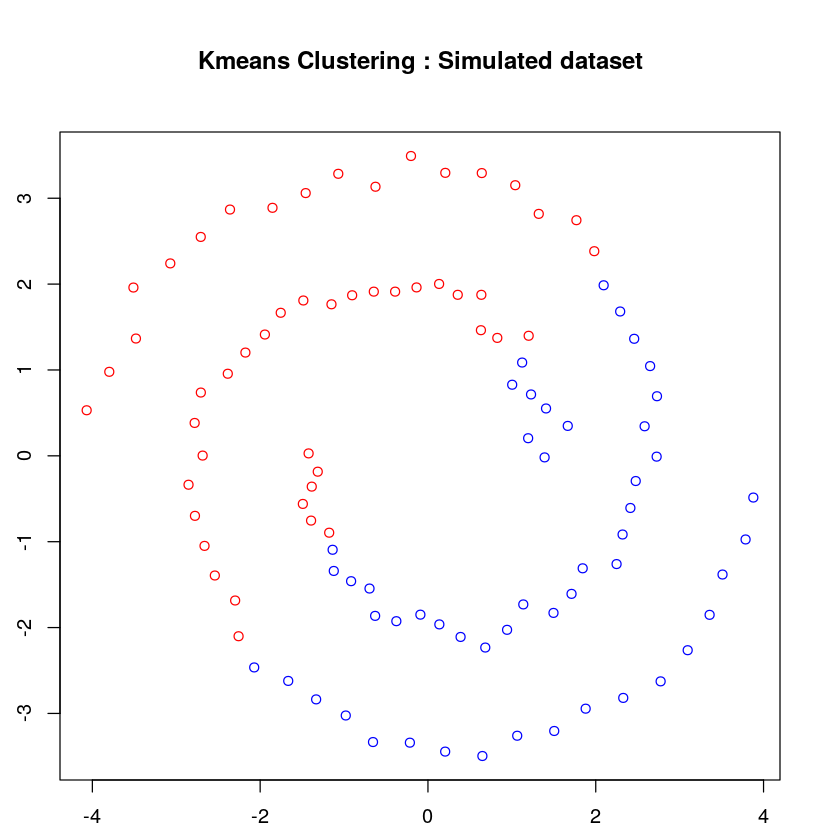

In [15]:
# clustering
kmcluster = iclusters(X,kmpp(X,2))
# plotting
pclusters(X,2,kmcluster,c("X1","X2"), col=c(2,4),
          "Kmeans Clustering : Simulated dataset")

* Clustering using Spectral Clustering :

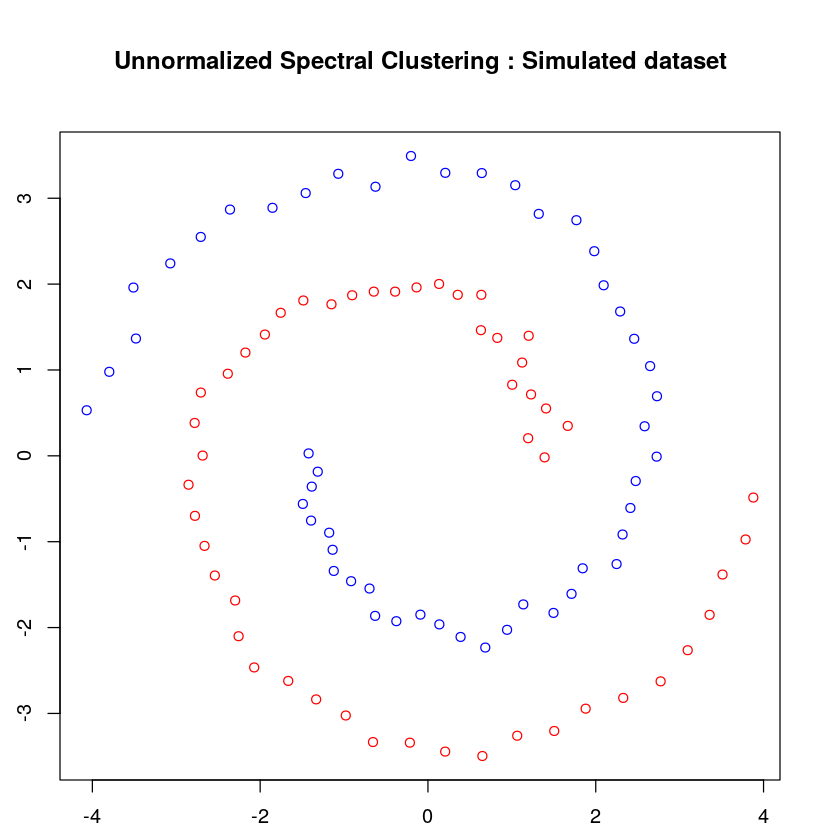

In [16]:
n = 100
# affinity matrix
A = matrix(0,n,n)
for (i in 1:n){
    for (j in 1:n){
        A[i,j] = exp(-8*dist2(X[,i],X[,j]))
    }
}
# ε-neighborhood graph
# clustering
spcluster = spec(A,2,0)
# plotting
pclusters(X,2,spcluster,c("X1","X2"), col=c(2,4),
          "Unnormalized Spectral Clustering : Simulated dataset")

The spectral clustering algorithm clearly outperforms kmeans++ in this simulated example.

## Iris Flower dataset

In this second numerical application, we use Fisher's Iris Flower Dataset. It consists of three classes of Iris flowers : 
    - Iris Setosa
    - Iris Versicolour
    - Iris Virginica

Each class contains 50 instances with the following measurements :
    1. sepal length in cm
    2. sepal width in cm
    3. petal length in cm
    4. petal width in cm 


In [17]:
d = read.csv(file="iris.data",head=F,sep=",")
d$V5<-factor(d$V5)
summary(d)

       V1              V2              V3              V4       
 Min.   :4.300   Min.   :2.000   Min.   :1.000   Min.   :0.100  
 1st Qu.:5.100   1st Qu.:2.800   1st Qu.:1.600   1st Qu.:0.300  
 Median :5.800   Median :3.000   Median :4.350   Median :1.300  
 Mean   :5.843   Mean   :3.054   Mean   :3.759   Mean   :1.199  
 3rd Qu.:6.400   3rd Qu.:3.300   3rd Qu.:5.100   3rd Qu.:1.800  
 Max.   :7.900   Max.   :4.400   Max.   :6.900   Max.   :2.500  
               V5    
 Iris-setosa    :50  
 Iris-versicolor:50  
 Iris-virginica :50  
                     
                     
                     

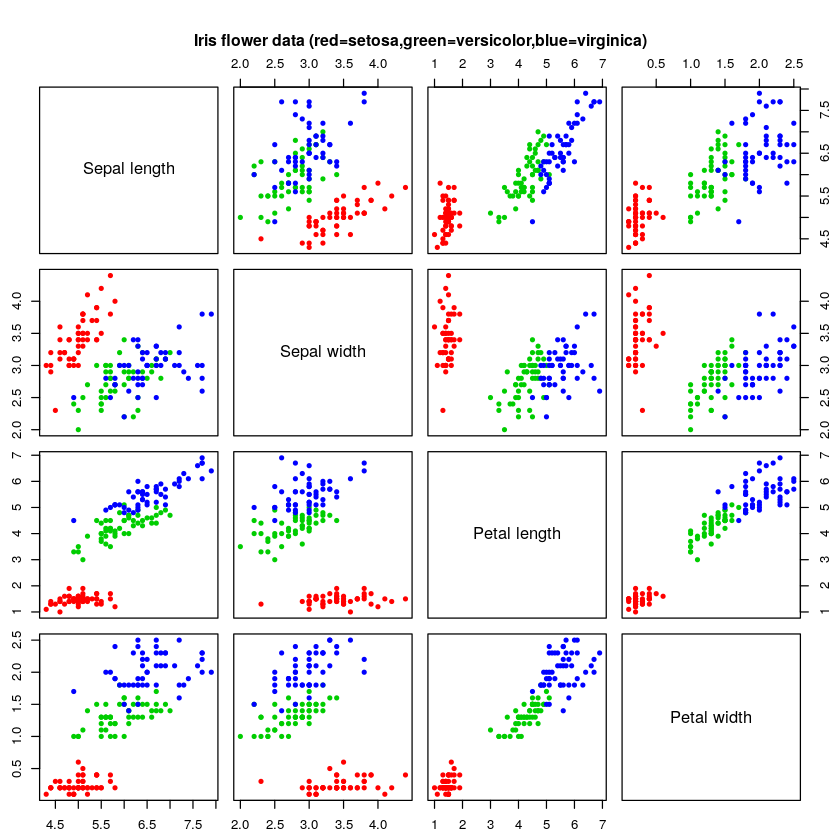

In [18]:
n = 150
X = t(matrix(c(d$V1,d$V2,d$V3,d$V4),nrow=n,ncol=4))
index = as.numeric(d$V5)
t = "Iris flower data (red=setosa,green=versicolor,blue=virginica)"
pclusters(X,3,index,c("Sepal length","Sepal width",
                      "Petal length","Petal width"),
          t ,shape=20)

* Clustering using Kmeans

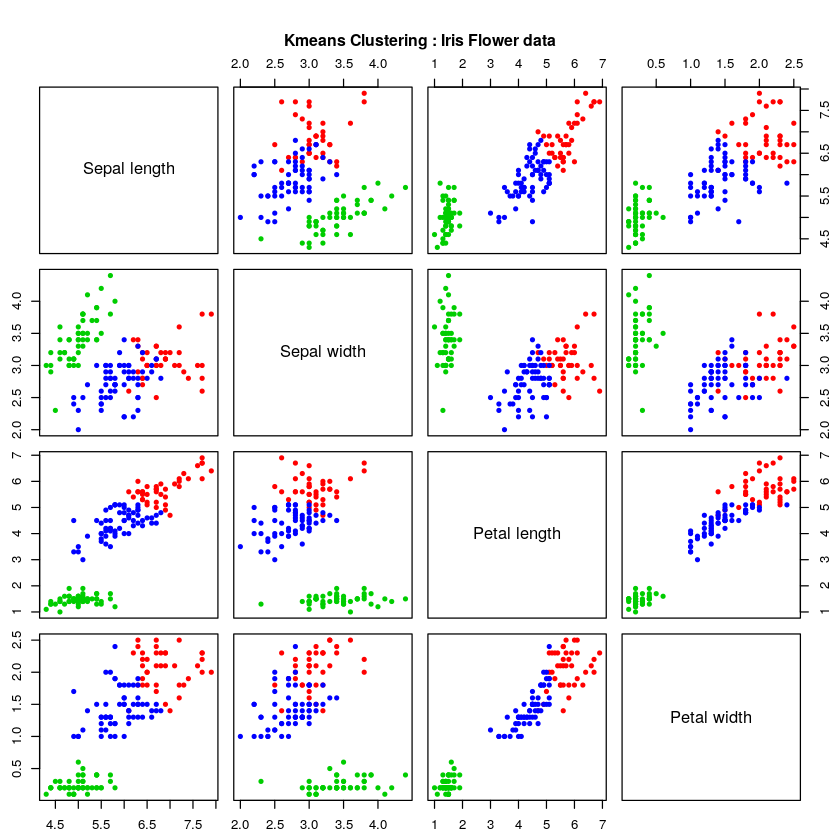

In [19]:
# clustering
kmcluster = iclusters(X,kmpp(X,3))
# plotting
pclusters(X,3,kmcluster,c("Sepal length","Sepal width",
                          "Petal length","Petal width"),
          "Kmeans Clustering : Iris Flower data", shape=20)

* Clustering using Spectral Clustering :

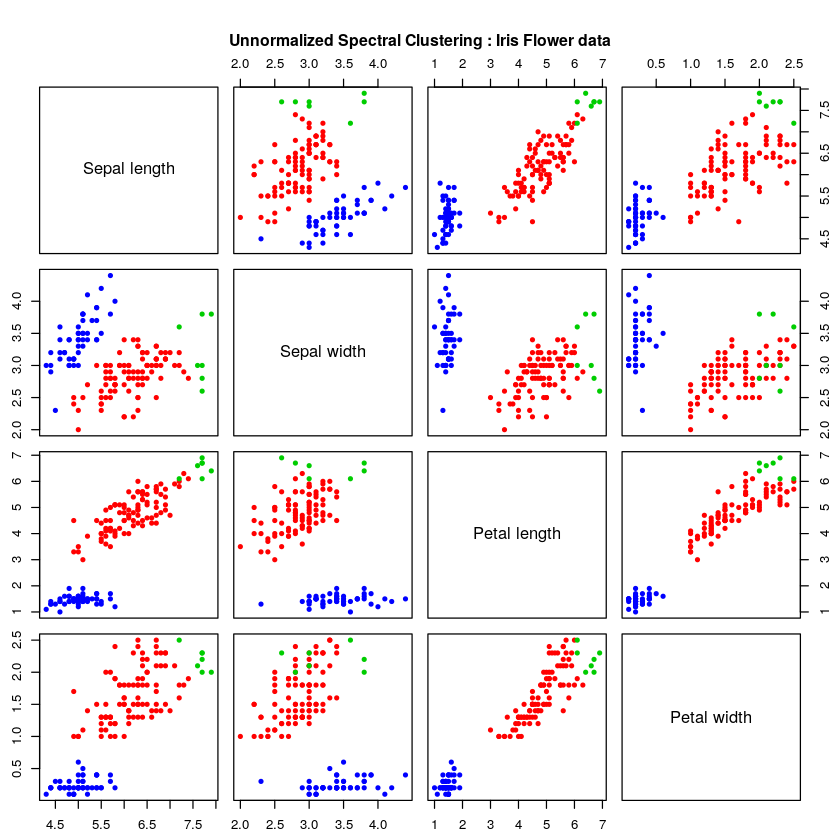

In [20]:
# distance matrix
D = matrix(0,n,n)
for (i in 1:n){
    for (j in 1:n){
        D[i,j] = dist2(X[,i],X[,j])
    }
}
# ε-neighborhood graph
e = 1
S = egraph(D,e)
# clustering
spcluster = spec(S,3,0)
# plotting
pclusters(X,3,spcluster,c("Sepal length","Sepal width",
                          "Petal length","Petal width"), 
          "Unnormalized Spectral Clustering : Iris Flower data",
          shape=20)

# Preliminary conclusions

So far, we can see that Kmeans++ outperforms Spectral Clustering on the Iris Flower dataset. Further study of the behavior of spectral clustering is needed to better understand its sensitivity to certain parameters.

# References

[1] von Luxburg, U., A Tutorial on Spectral Clustering, in *Statistics and Computing*, 17 (4), 2007.

[2] Arthur D, Vassilvitskii S (2007) k-means++: the advantages of careful seeding. Proceedings of the Eighteenth Annual ACM-SIAM Symposium on Discrete Algorithms. pp 1027--1035.

[3] Fisher,R.A. "The use of multiple measurements in taxonomic problems" Annual Eugenics, 7, Part II, 179-188 (1936); also in "Contributions to Mathematical Statistics" (John Wiley, NY, 1950). 